In [1]:
%pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 51.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import functools
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn import metrics


warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
import sweetviz as sv

In [6]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [8]:
file_path = "/kaggle/input/playground-series-s3e12/"

In [9]:
train_df = pd.read_csv(file_path+"train.csv")
test_df = pd.read_csv(file_path+"test.csv")

                                             |          | [  0%]   00:00 -> (? left)


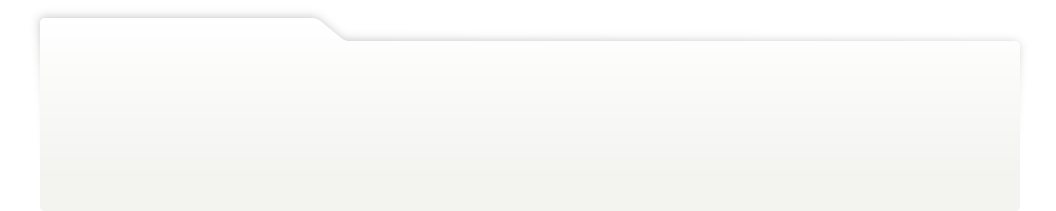
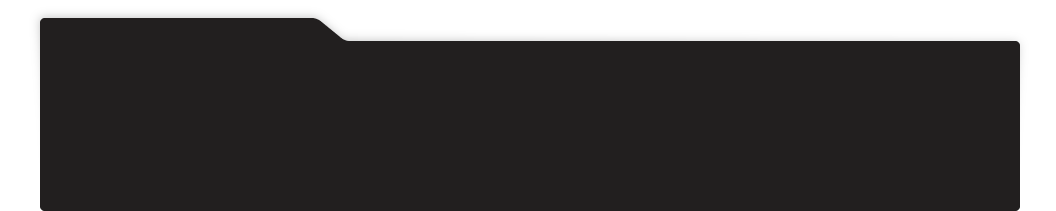
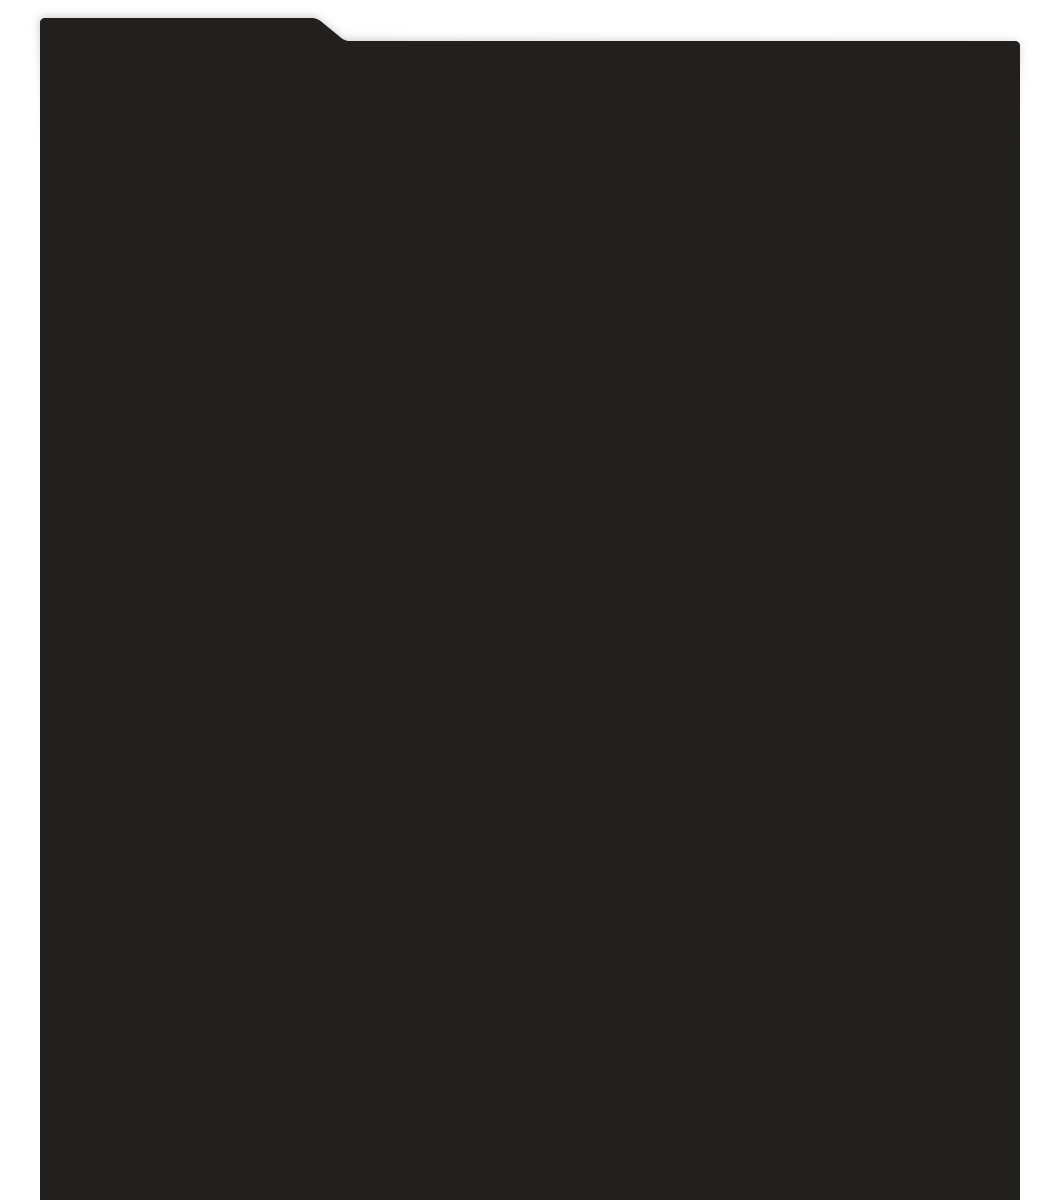
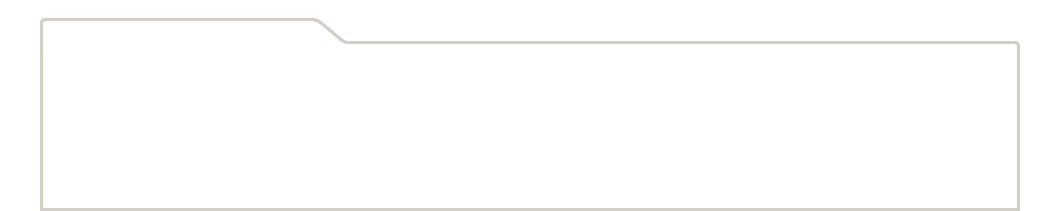
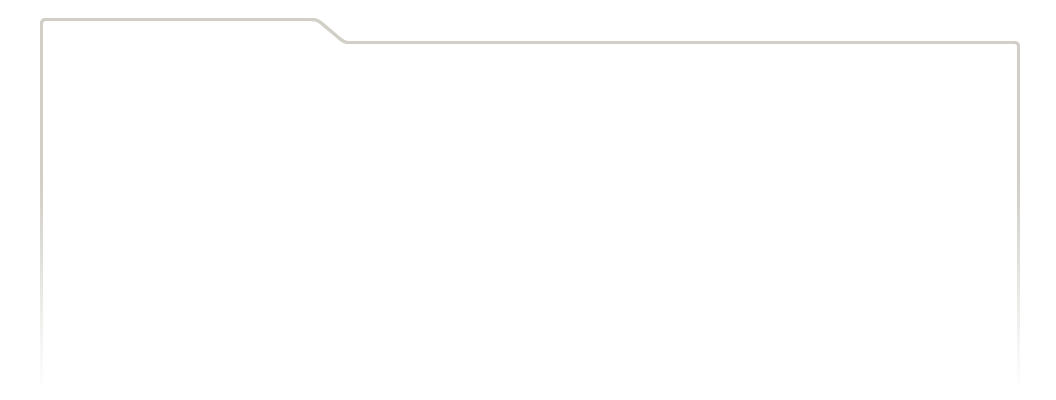
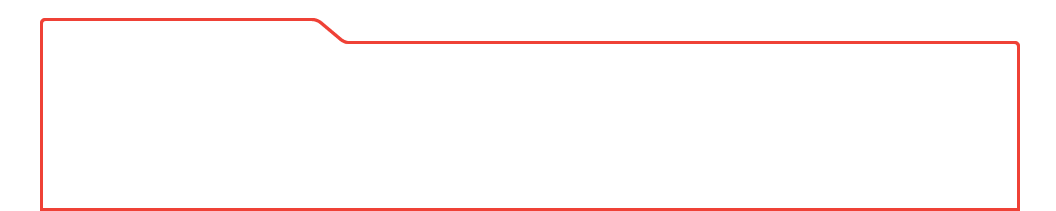
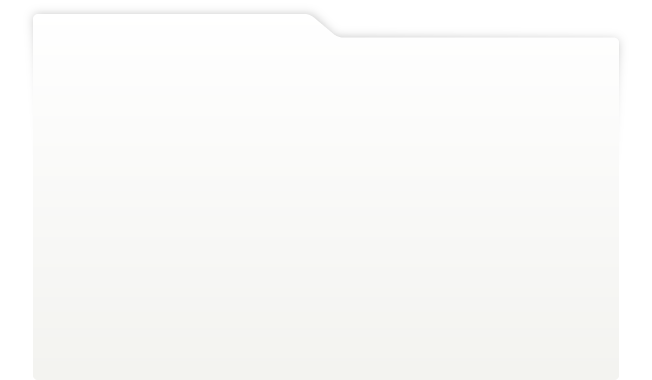
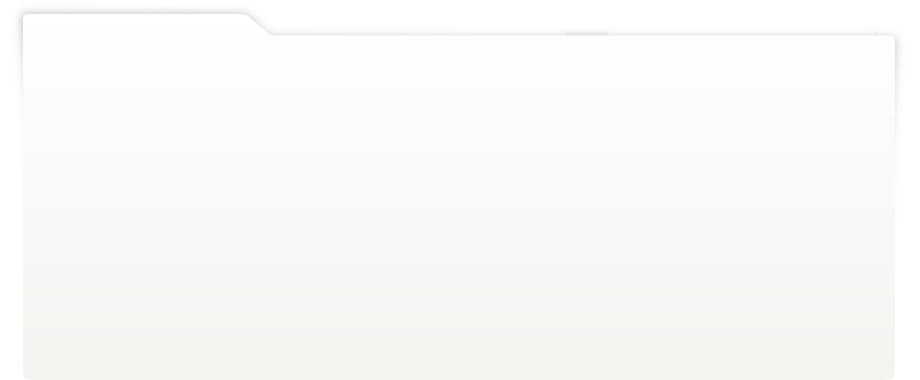
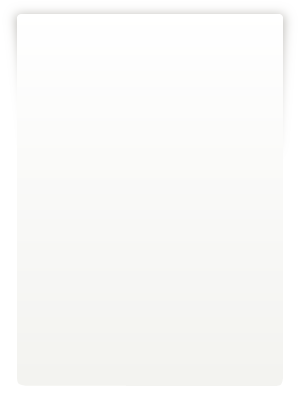
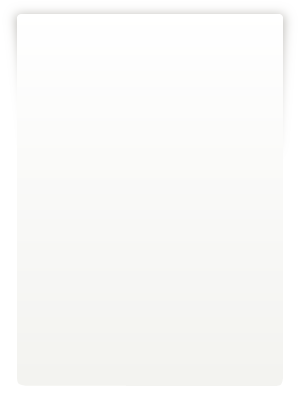
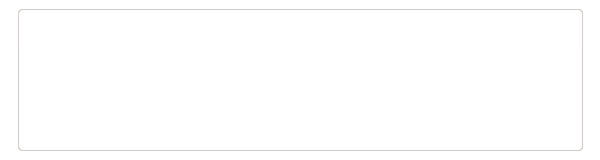
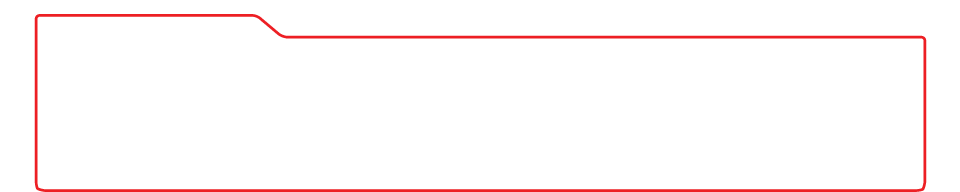
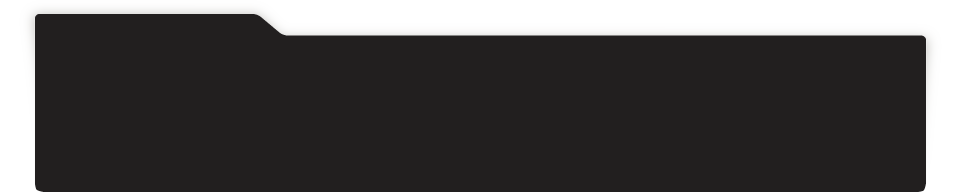
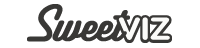
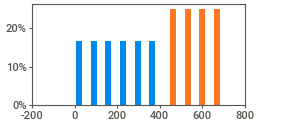
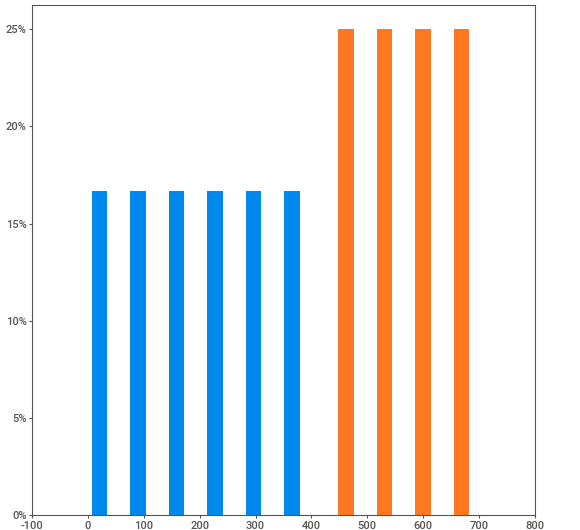
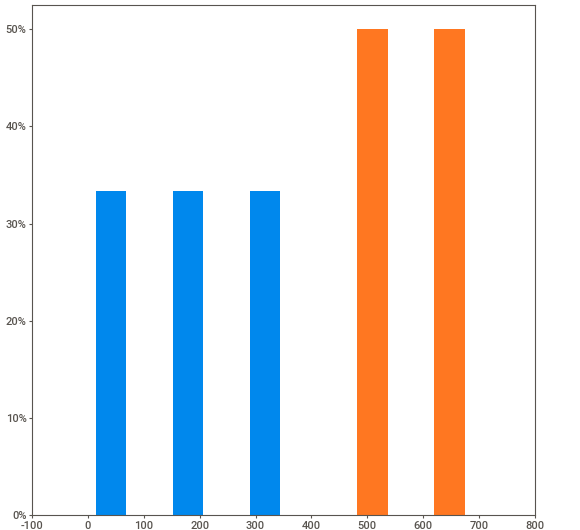
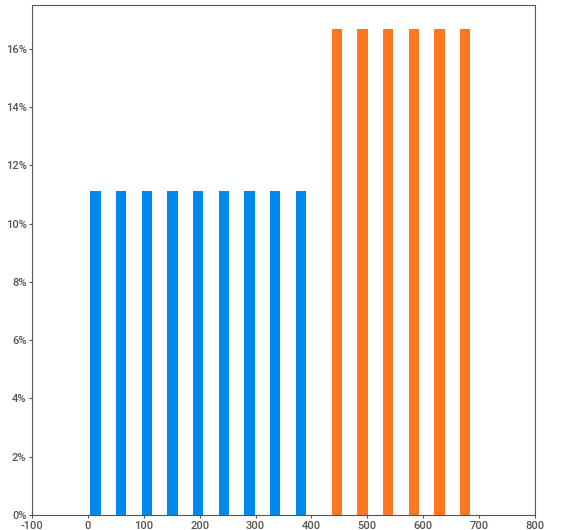
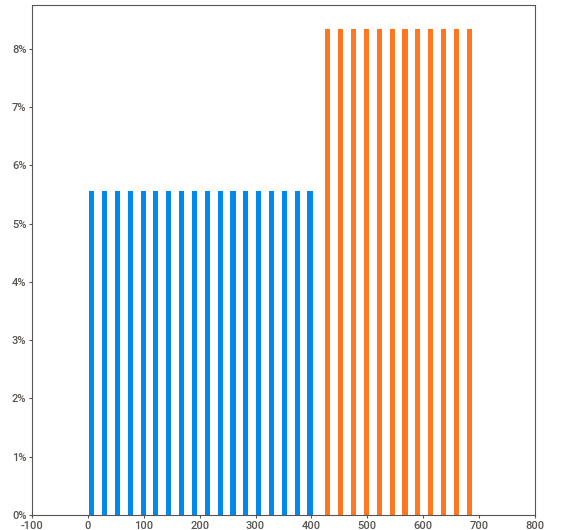
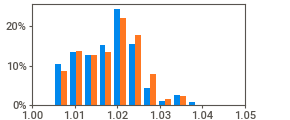
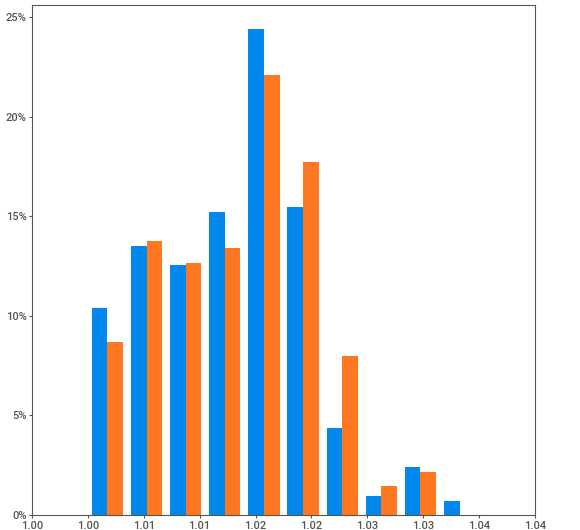
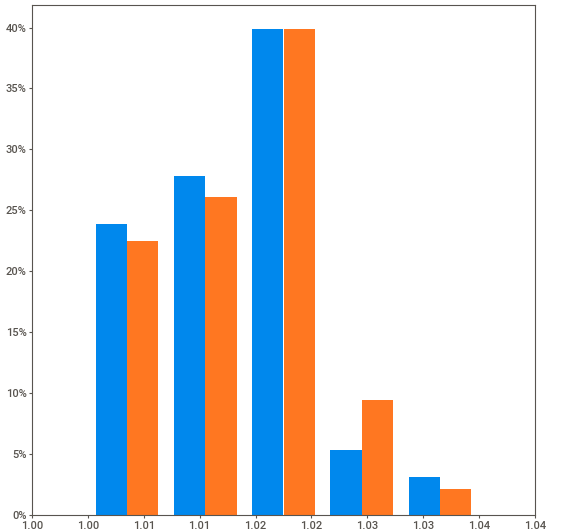
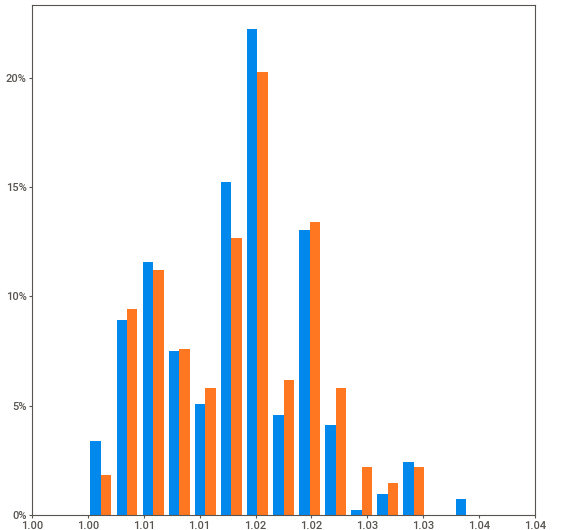
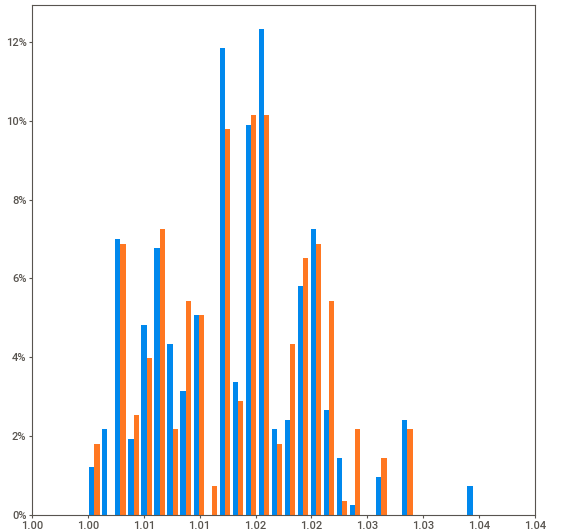
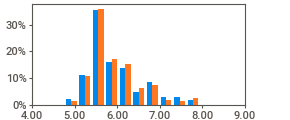
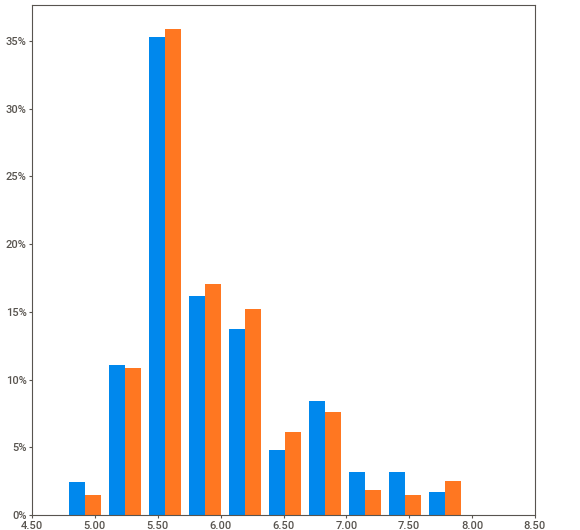
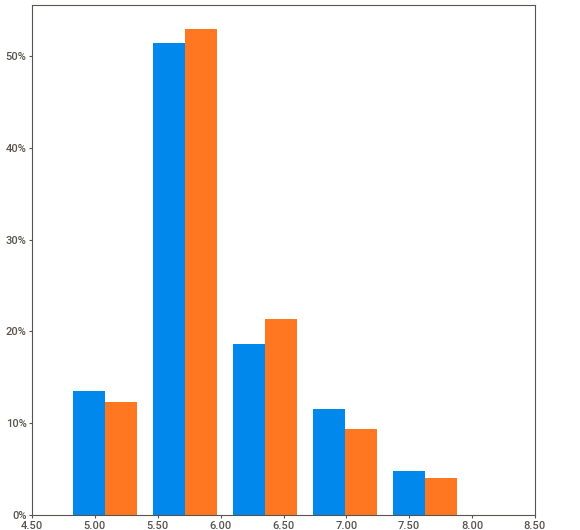
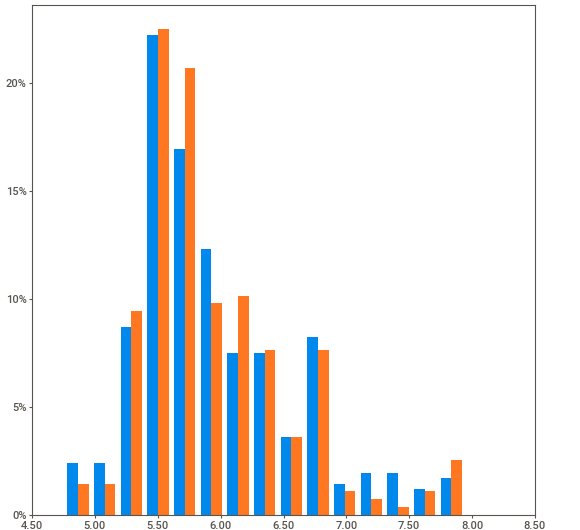
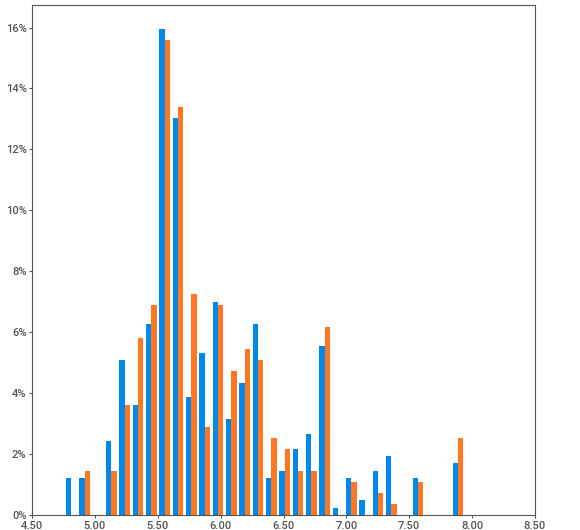
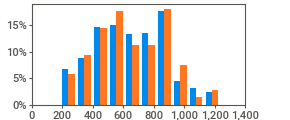
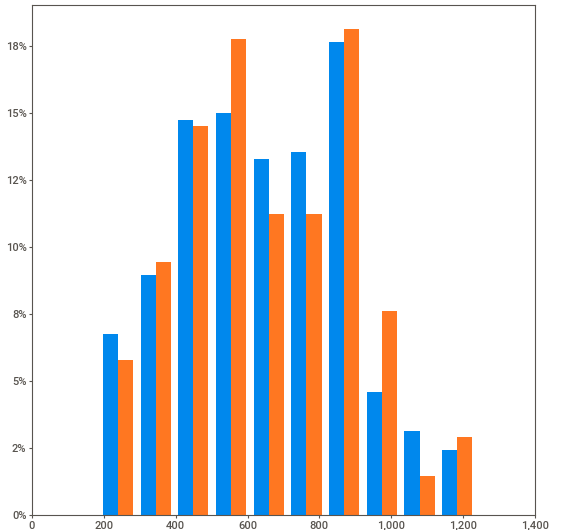
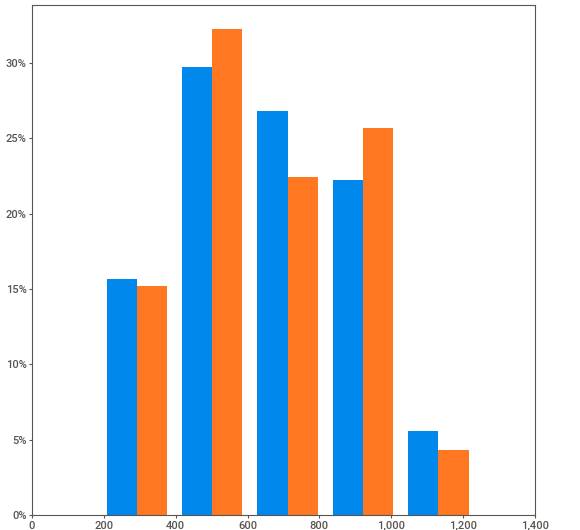
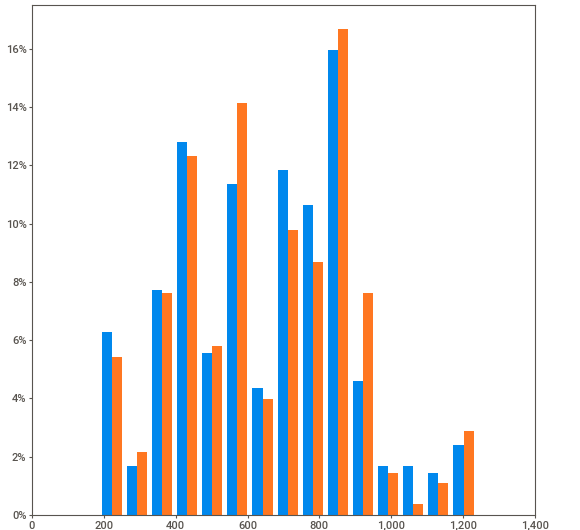
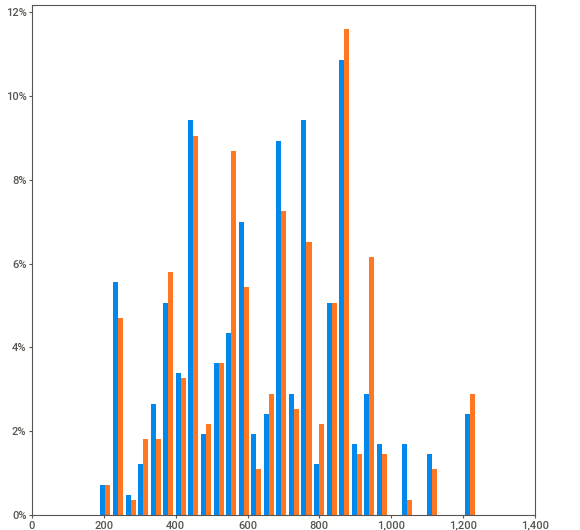
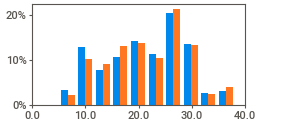
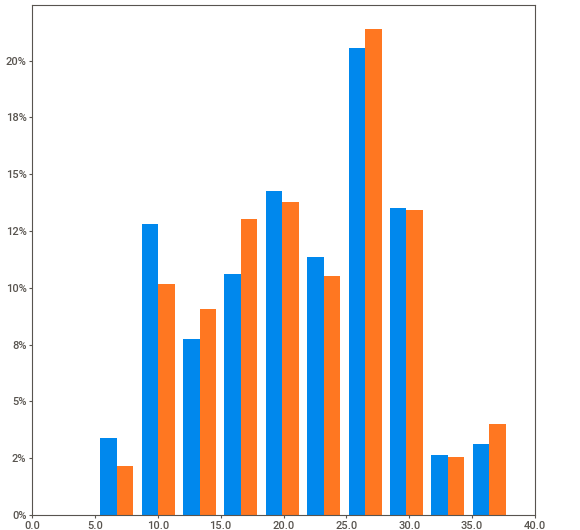
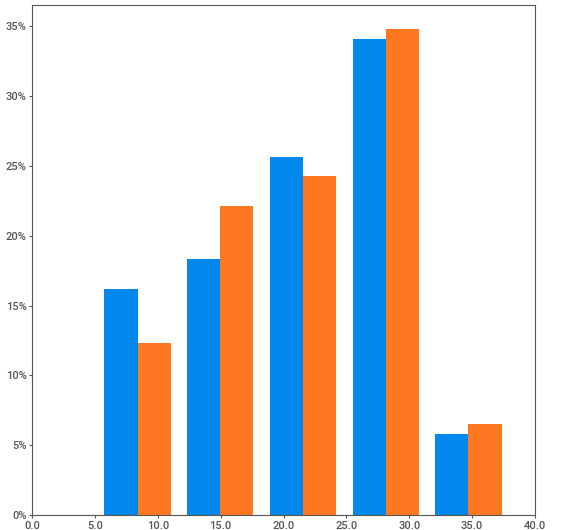
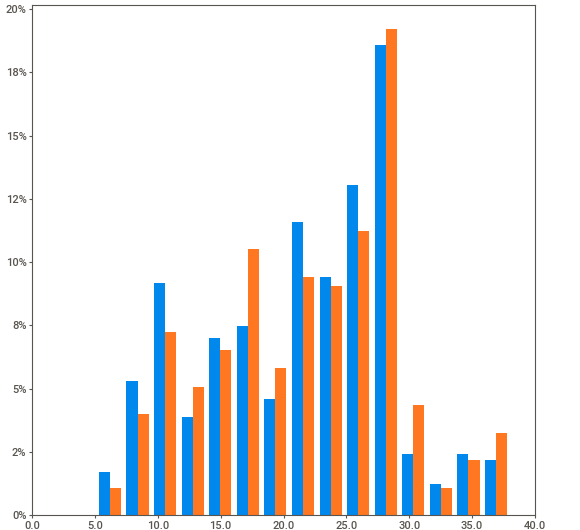
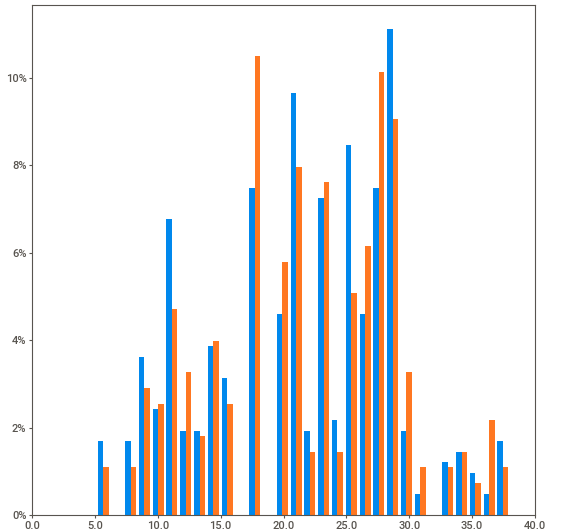
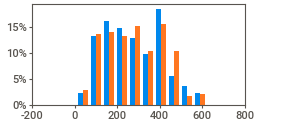
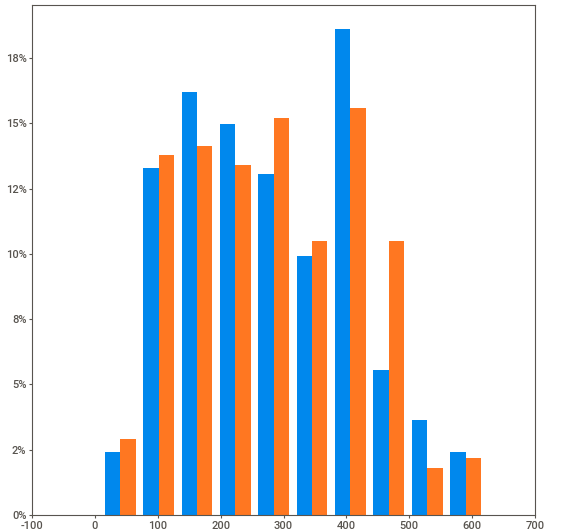
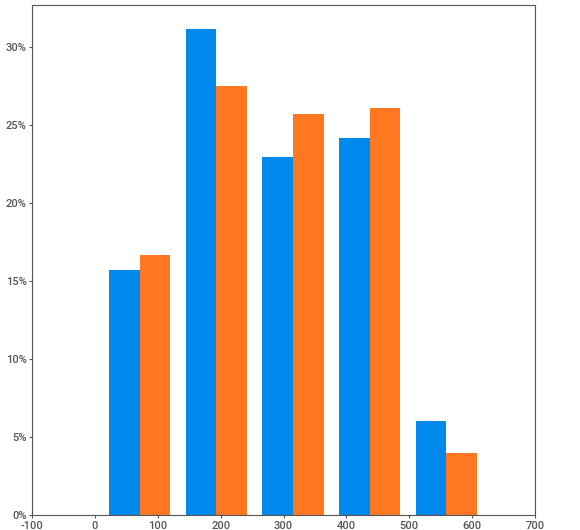
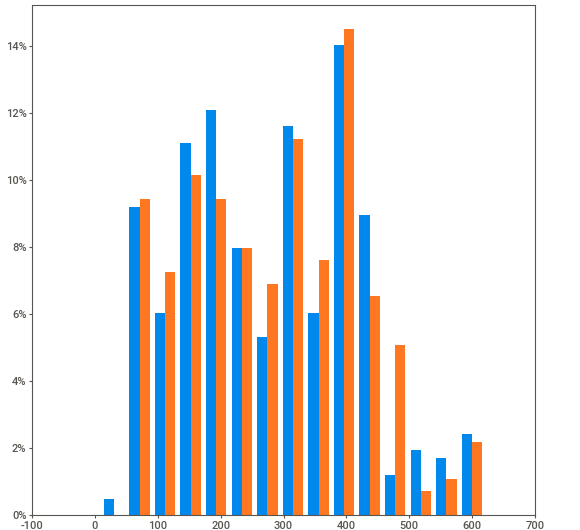
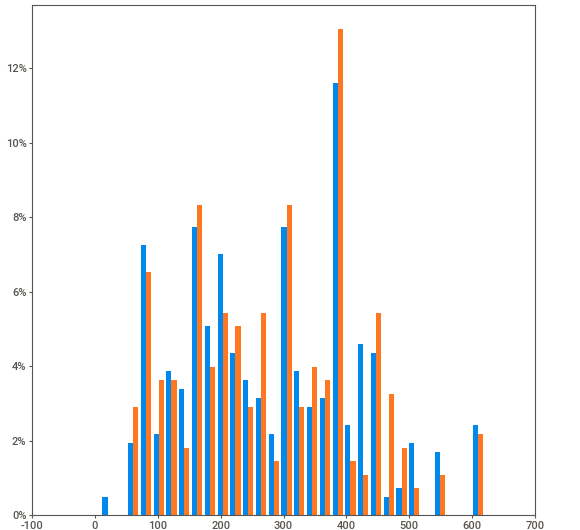
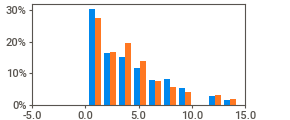
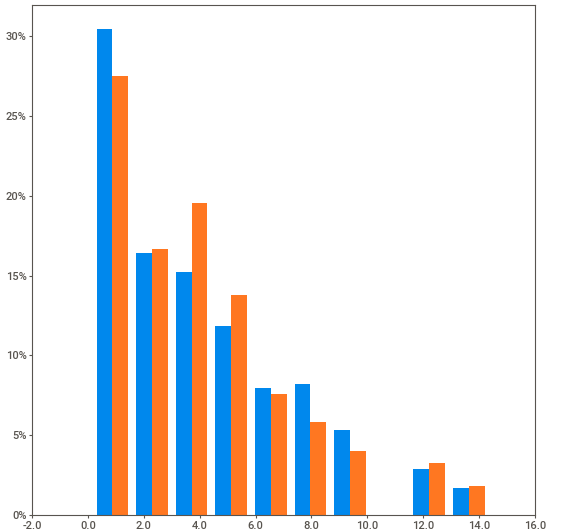
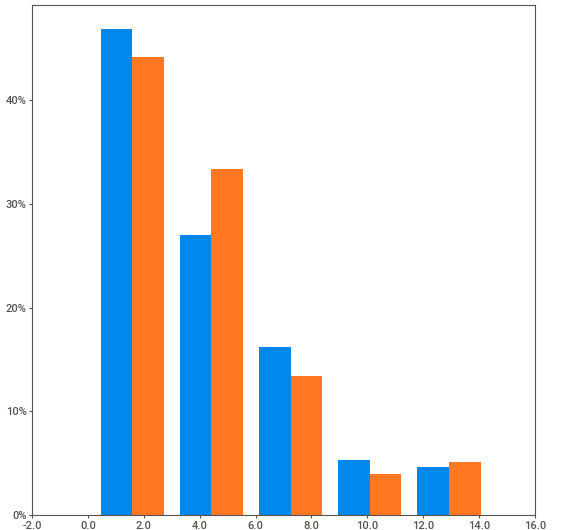
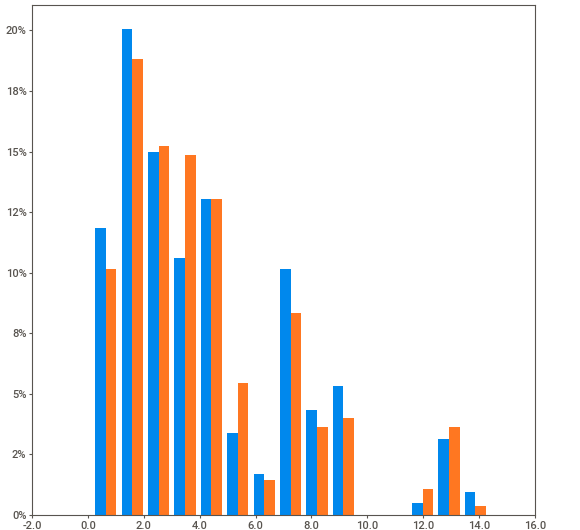
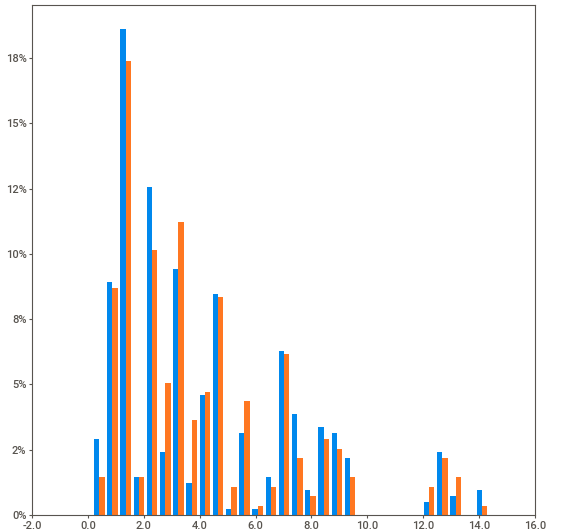
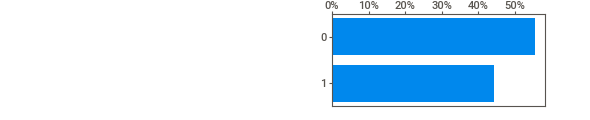
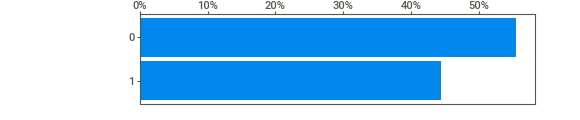
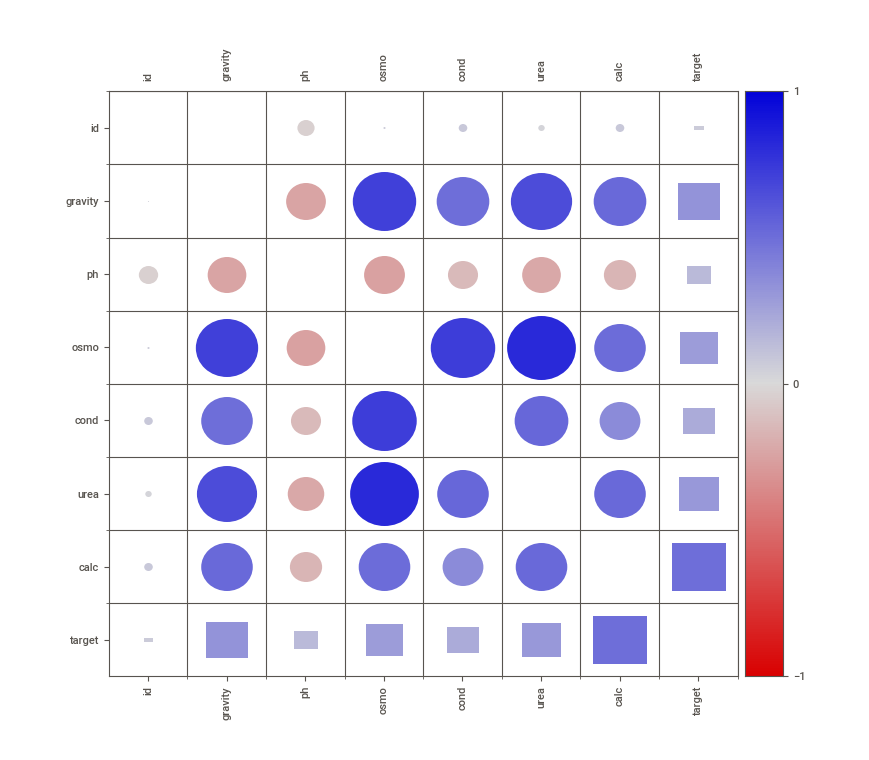
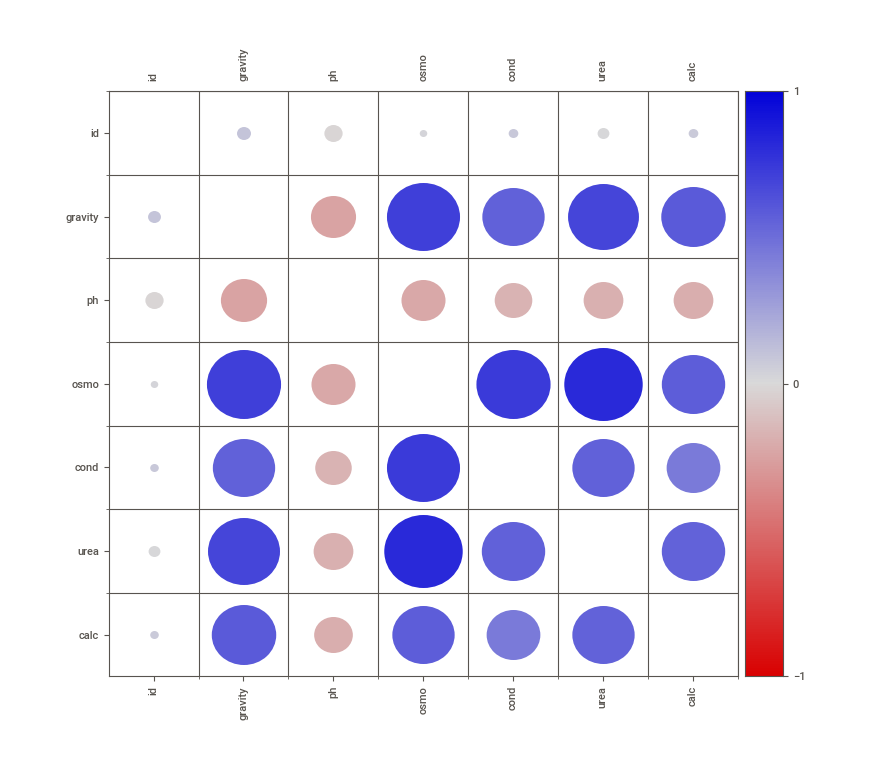

In [10]:
my_report_cmp = sv.compare(train_df,test_df)
my_report_cmp.show_notebook(w="100%", h="full") # if working in Kaggle


                                             |          | [  0%]   00:00 -> (? left)


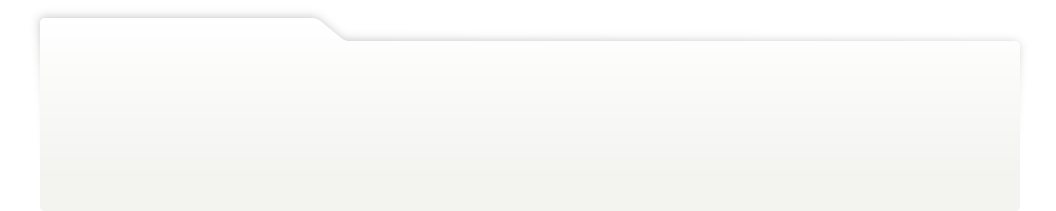
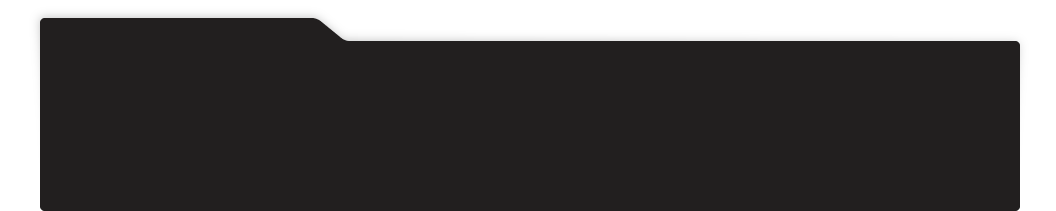
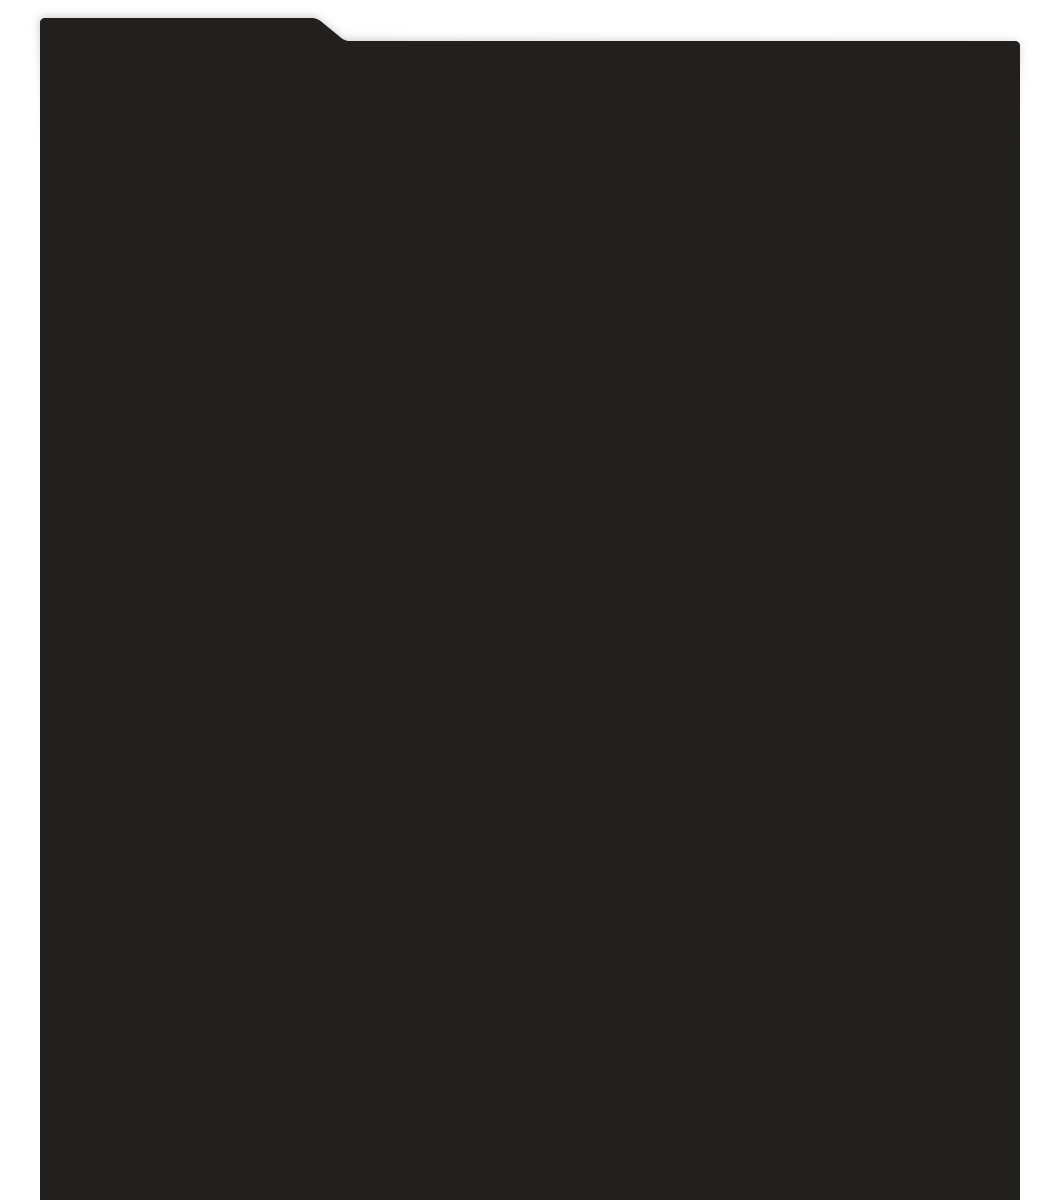
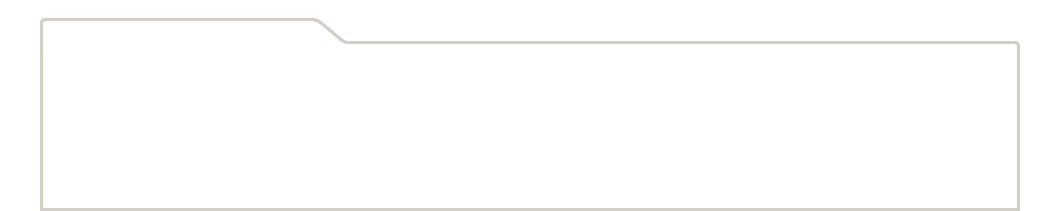
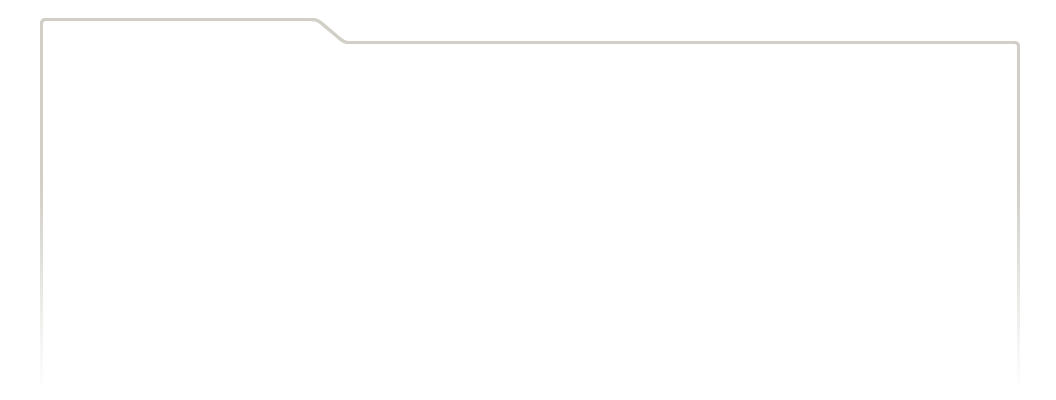
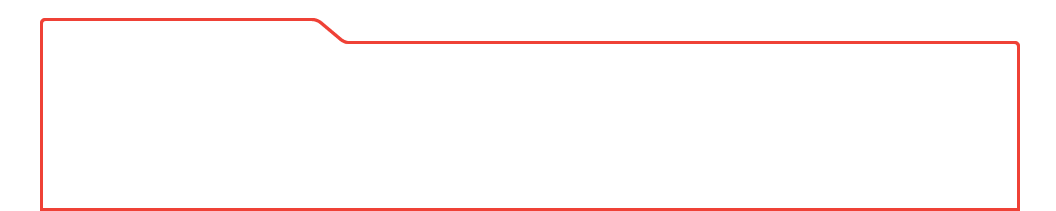
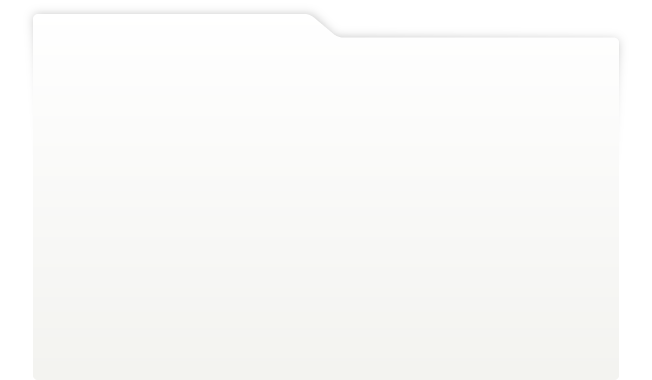
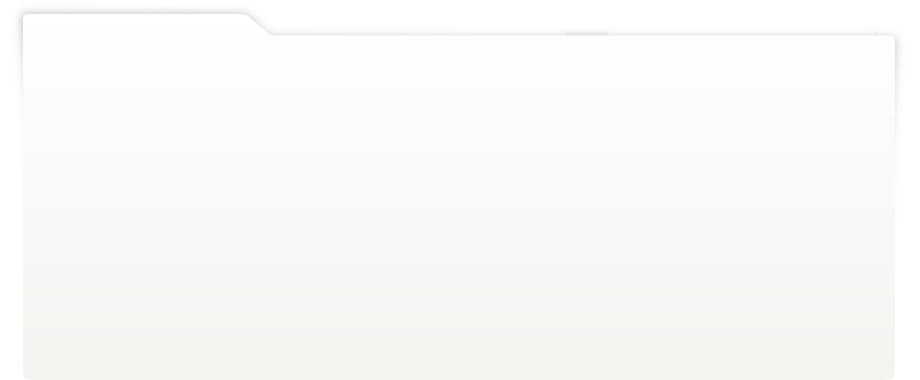
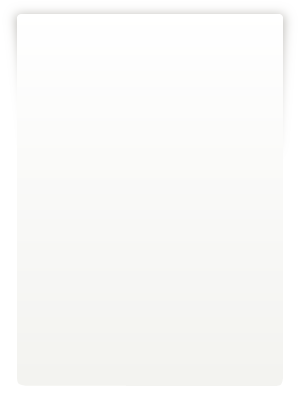
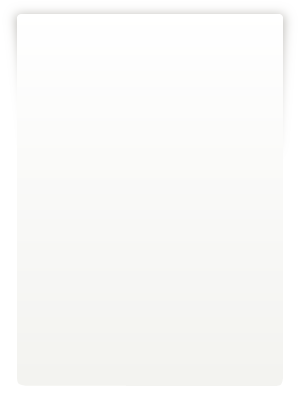
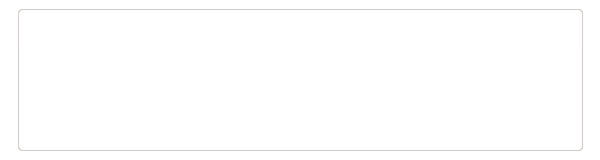
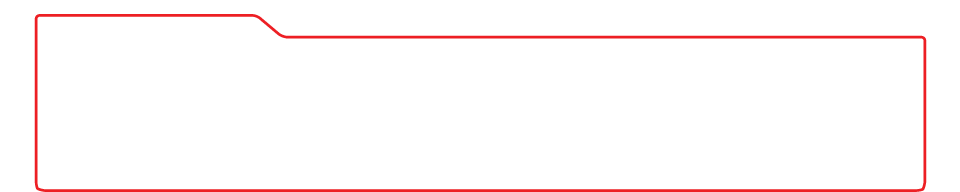
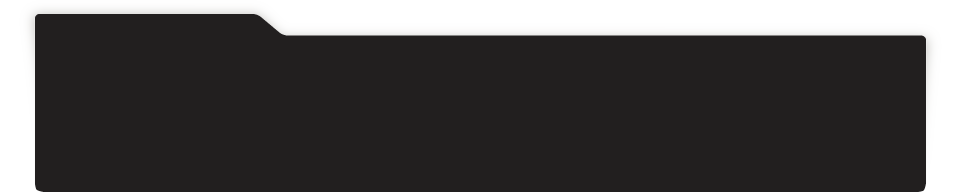
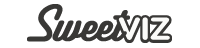
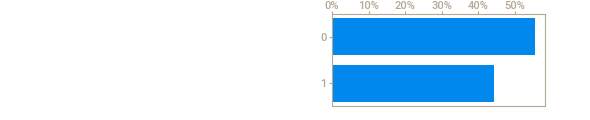
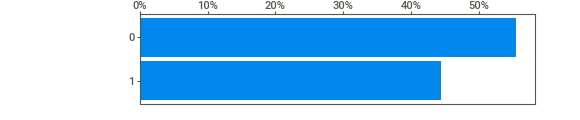
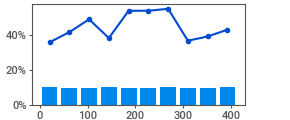
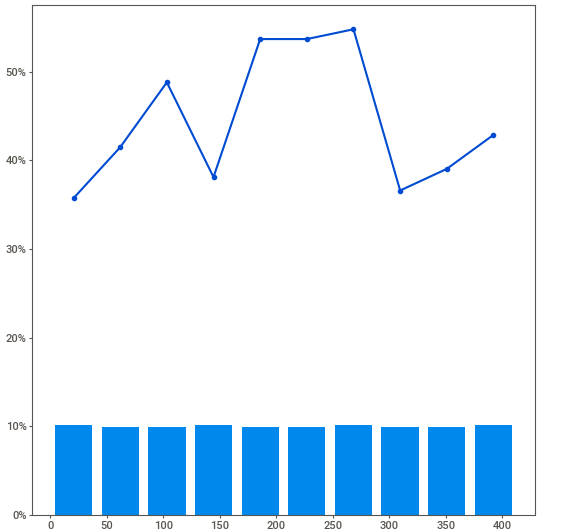
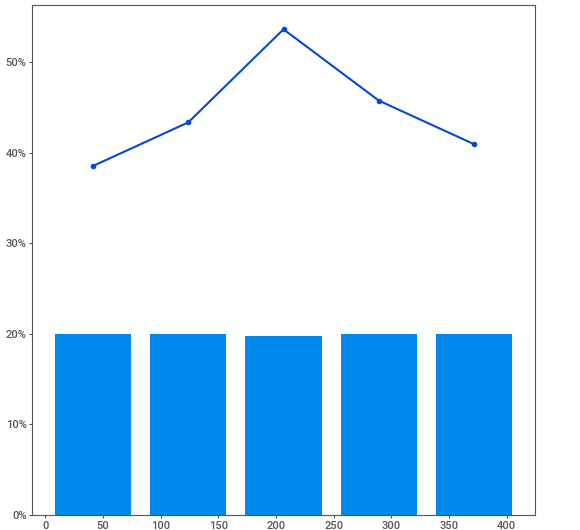
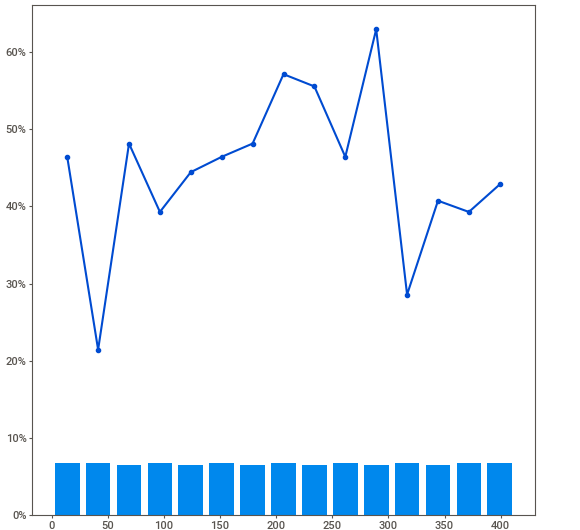
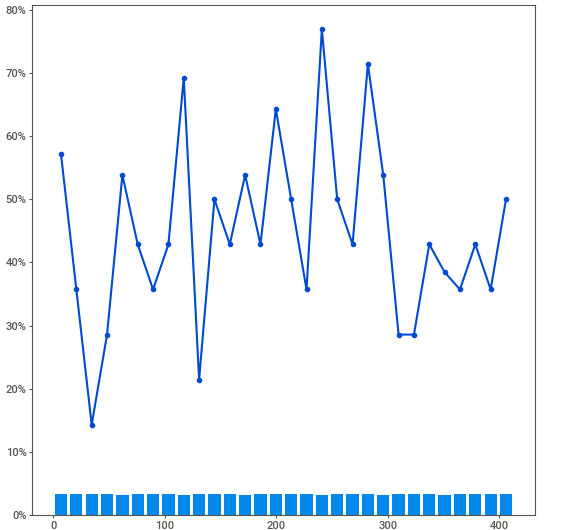
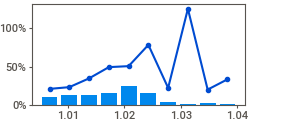
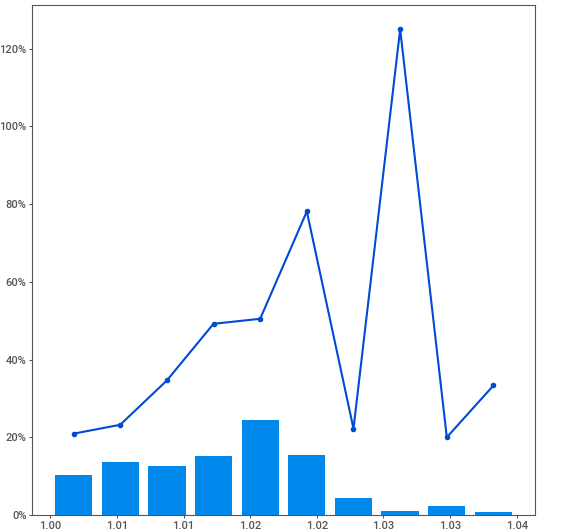
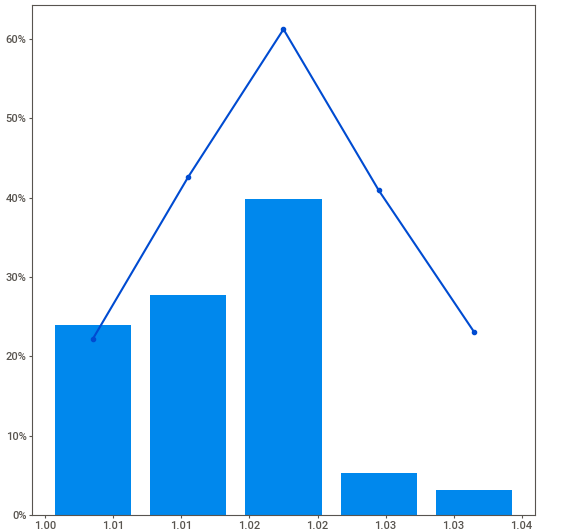
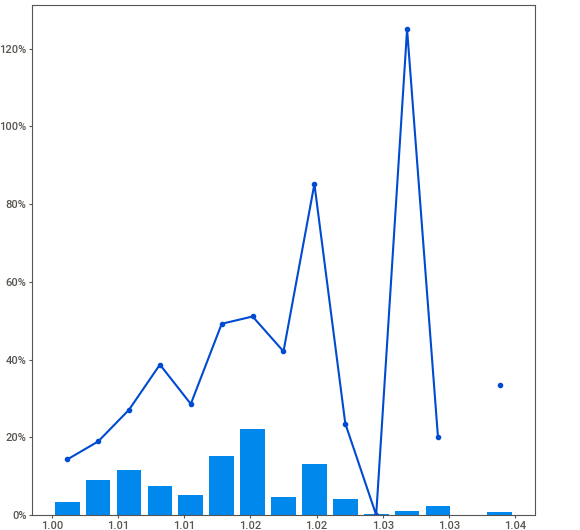
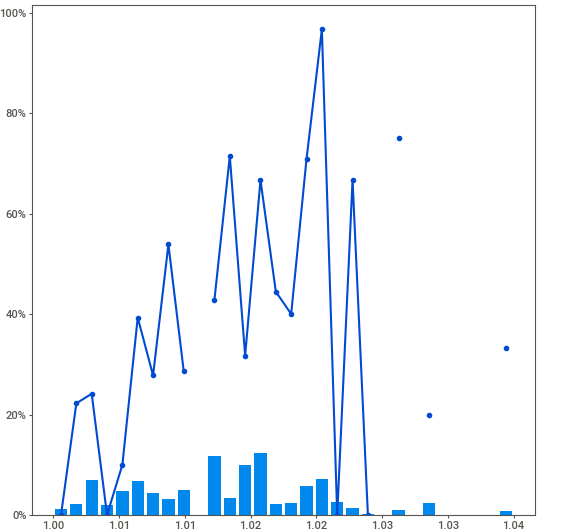
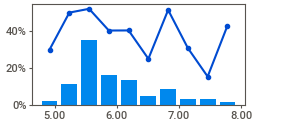
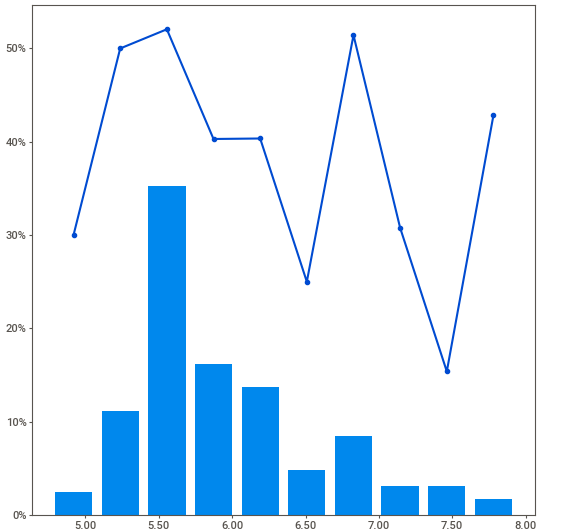
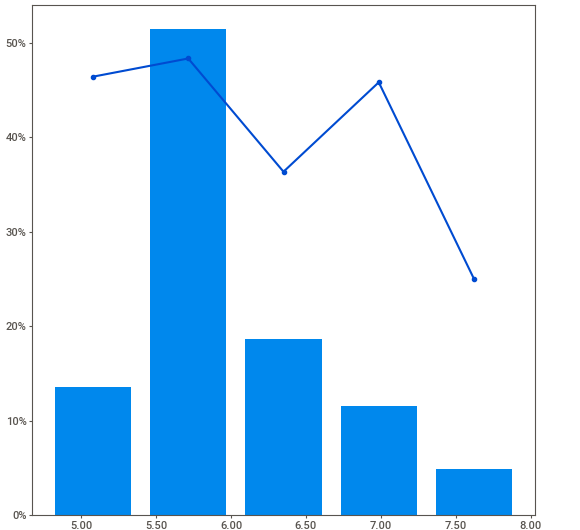
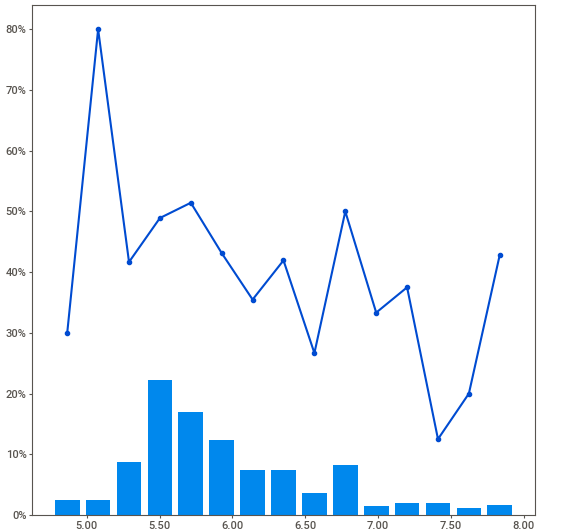
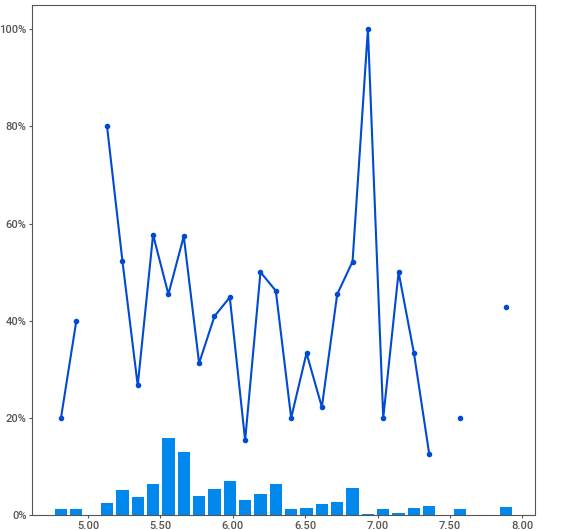
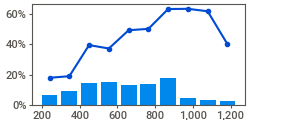
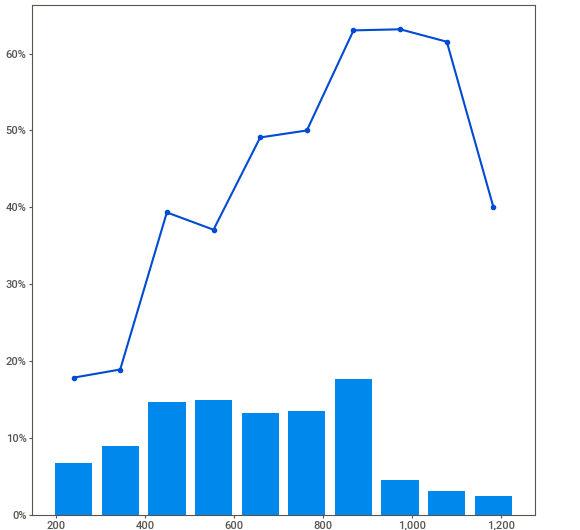
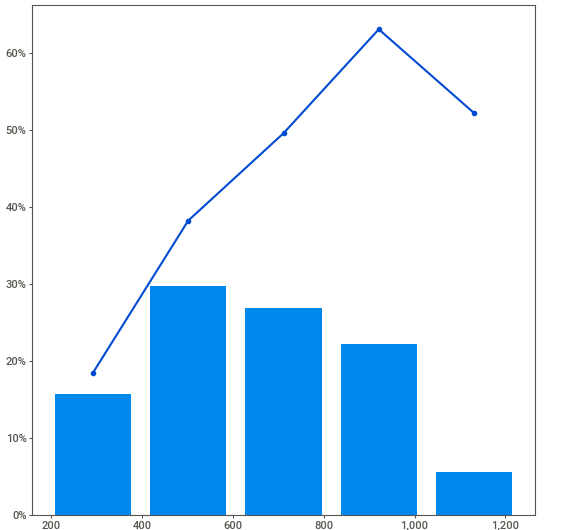
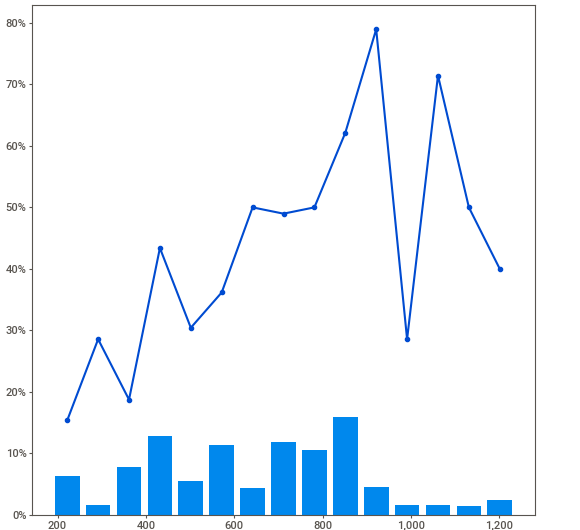
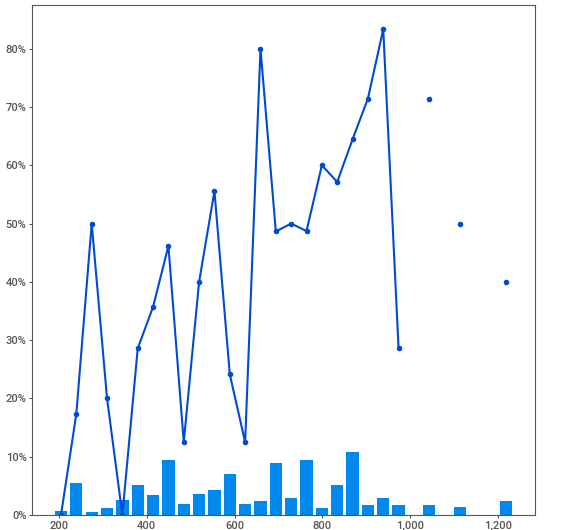
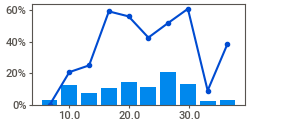
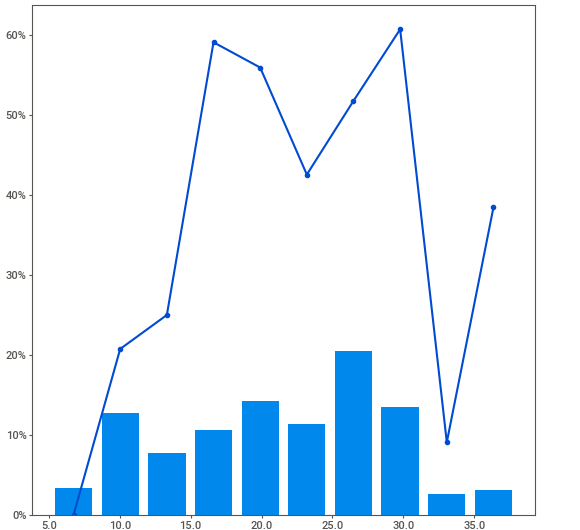
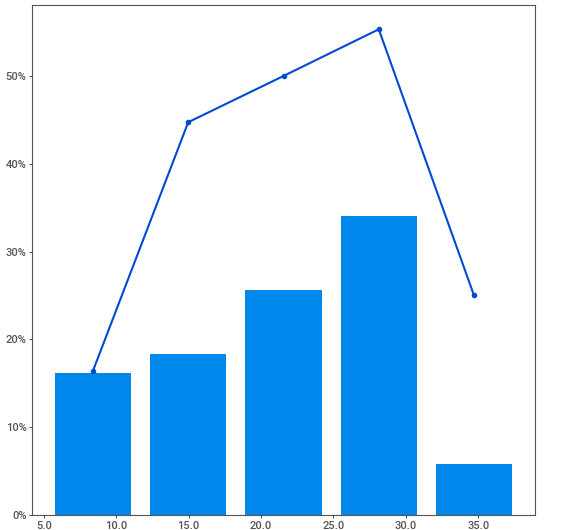
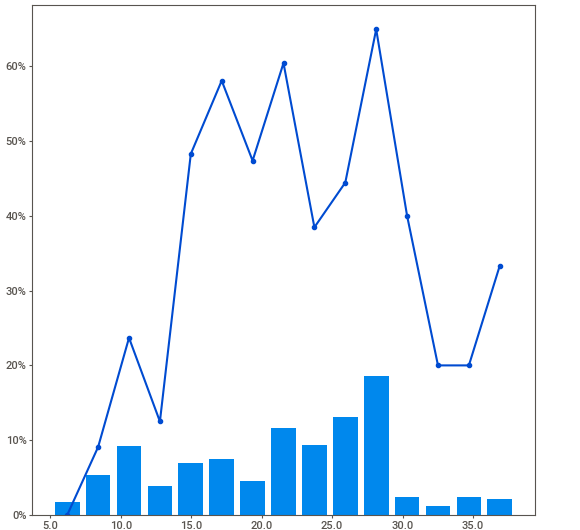
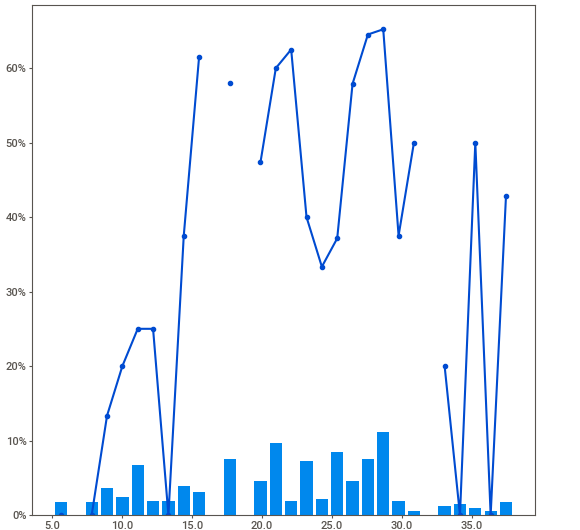
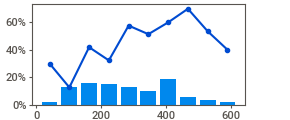
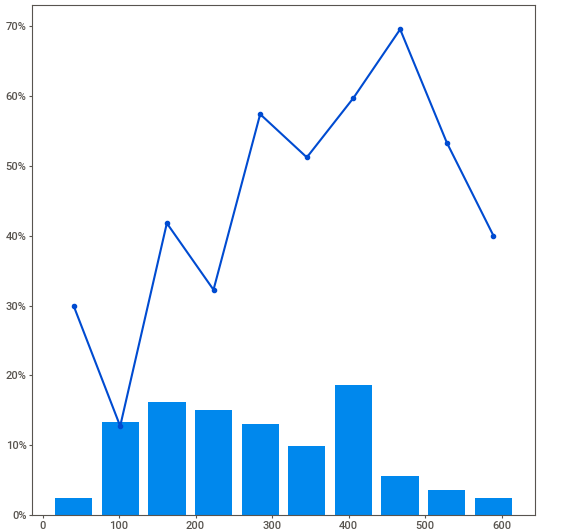
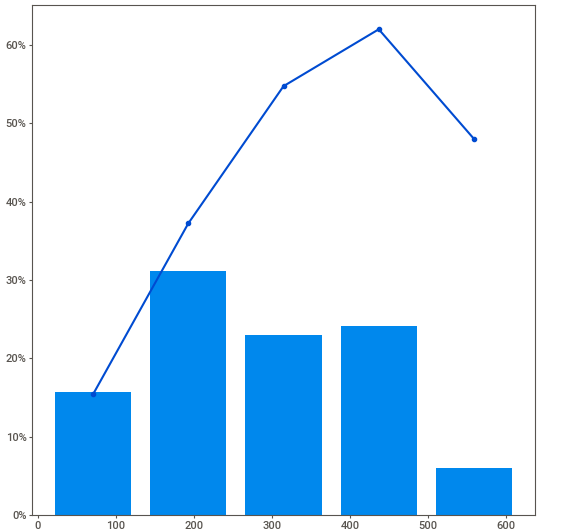
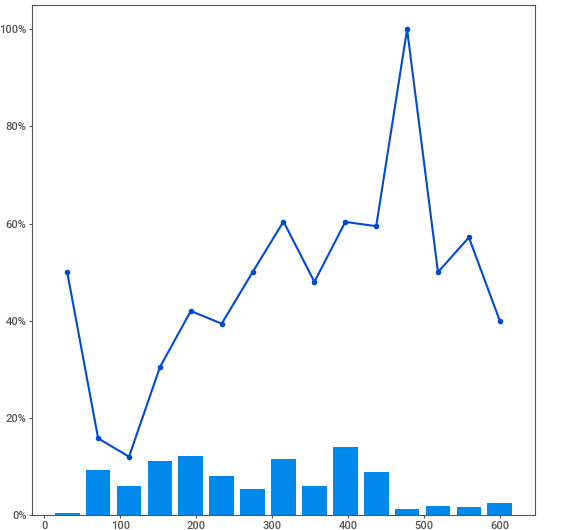
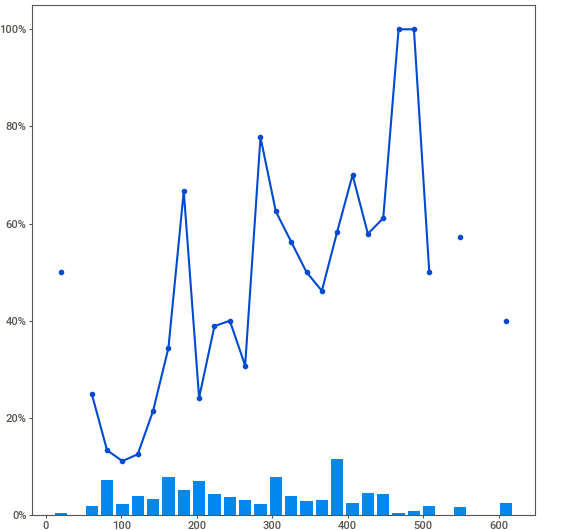
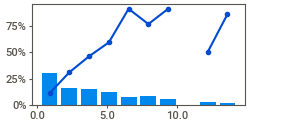
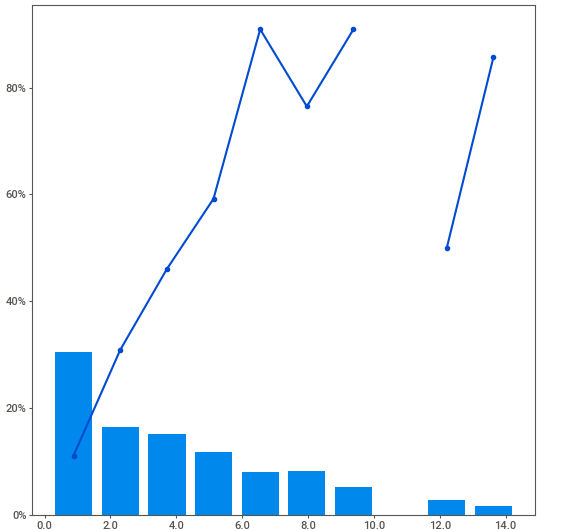
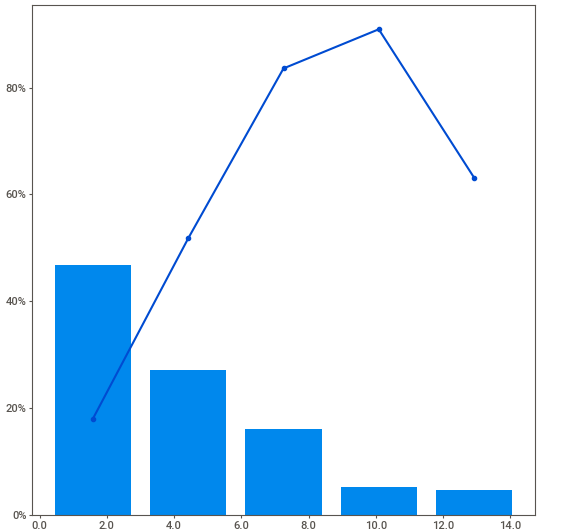
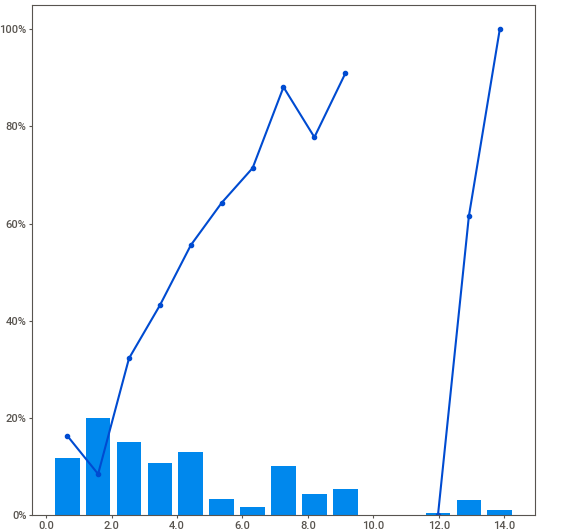
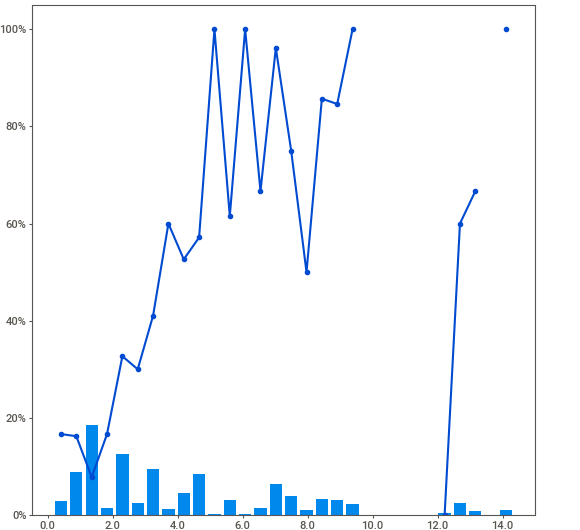
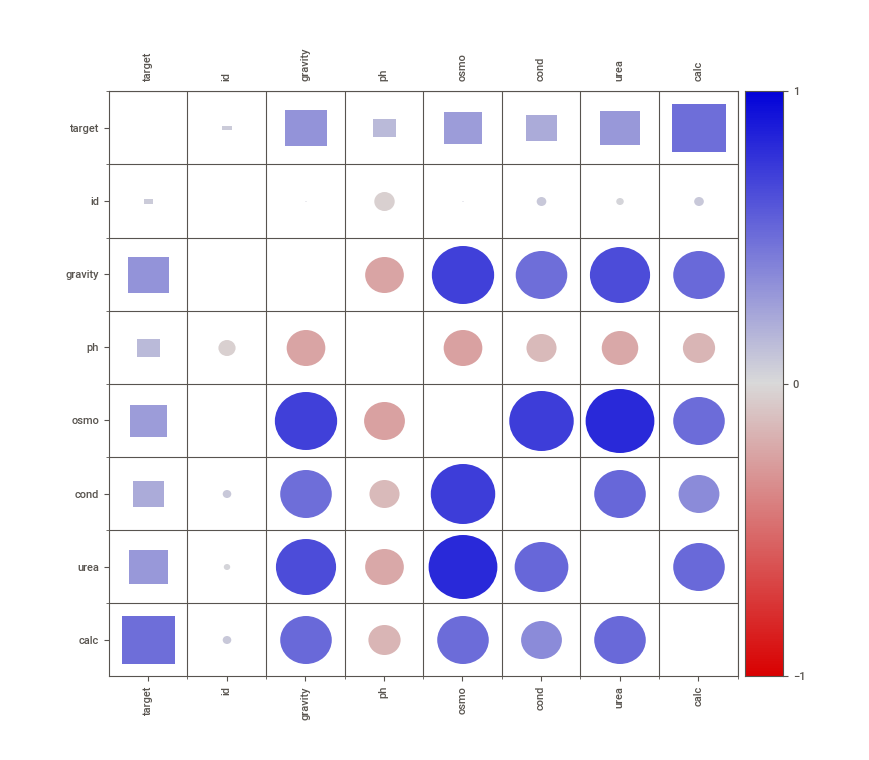
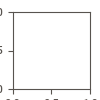

In [11]:
my_report = sv.analyze(train_df,target_feat='target')
my_report.show_notebook(w="100%", h="full") # if working in Kaggle


In [12]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [13]:
train_y = train_df.pop('target')

In [14]:
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold

from keras import models
from keras import layers
from tensorflow import keras
import tensorflow as tf
from pytorch_tabnet.tab_model import TabNetClassifier


In [15]:
scaler = StandardScaler()
train_x_scaled = pd.DataFrame(scaler.fit_transform(train_df),
                     columns = train_df.columns)

test_x_scaled = scaler.transform(test_df)

In [16]:
df = train_df

nunique = df.nunique()
types = df.dtypes


categorical_columns = []
categorical_dims =  {}
for col in df.columns:
    if types[col] == 'object' and nunique[col] < 200:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = df[col].fillna("VV_likely")
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
#     else:
#         df.fillna(df.loc[train_indices, col].mean(), inplace=True)

In [17]:
unused_feat = ['Set']

features = [ col for col in df.columns if col not in unused_feat+['target']] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [18]:
grouped_features = [] #[[0, 1, 2], [8, 9, 10]]

# Tabnet

In [19]:
X = df
y = train_y

In [20]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
#                  "mask_type":'entmax', # "sparsemax"
#                  "grouped_features" : grouped_features
                }

In [21]:

# Define KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate model with KFold cross-validation
save_history = []
for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Define TabNetClassifier model
    clf = TabNetClassifier(**tabnet_params)

    # Train model
    clf.fit(
        X_train=X_train.values,
        y_train=y_train.values,
        eval_set=[(X_test.values, y_test.values)],
        eval_name=['val'],
        eval_metric=['logloss','auc'],
        patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    save_history.append(clf.history["val_auc"])

epoch 0  | loss: 0.84363 | val_logloss: 7.81673 | val_auc: 0.7152  |  0:00:00s
epoch 1  | loss: 0.65796 | val_logloss: 2.77637 | val_auc: 0.6924  |  0:00:00s
epoch 2  | loss: 0.61634 | val_logloss: 7.86343 | val_auc: 0.53275 |  0:00:00s
epoch 3  | loss: 0.61387 | val_logloss: 11.98156| val_auc: 0.28596 |  0:00:00s
epoch 4  | loss: 0.59608 | val_logloss: 9.80685 | val_auc: 0.35994 |  0:00:00s
epoch 5  | loss: 0.57786 | val_logloss: 9.42494 | val_auc: 0.3845  |  0:00:00s
epoch 6  | loss: 0.59523 | val_logloss: 8.83056 | val_auc: 0.3652  |  0:00:00s
epoch 7  | loss: 0.4769  | val_logloss: 8.24167 | val_auc: 0.36579 |  0:00:00s
epoch 8  | loss: 0.54292 | val_logloss: 8.14887 | val_auc: 0.37222 |  0:00:00s
epoch 9  | loss: 0.54629 | val_logloss: 7.89144 | val_auc: 0.38099 |  0:00:00s
epoch 10 | loss: 0.53386 | val_logloss: 7.88627 | val_auc: 0.37105 |  0:00:00s
epoch 11 | loss: 0.5125  | val_logloss: 7.63086 | val_auc: 0.3693  |  0:00:00s
epoch 12 | loss: 0.54425 | val_logloss: 7.38883 | va

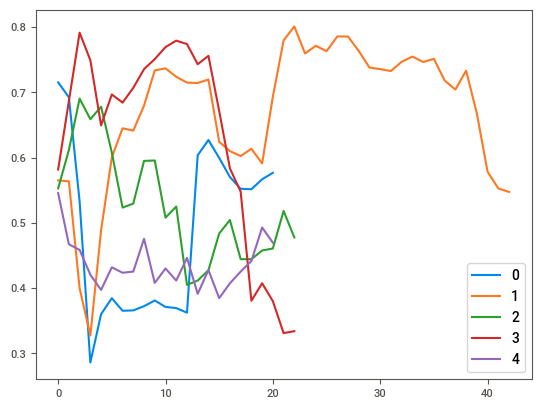

In [22]:
for idx, i in enumerate(save_history):
    plt.plot(i, label=idx)
plt.legend()

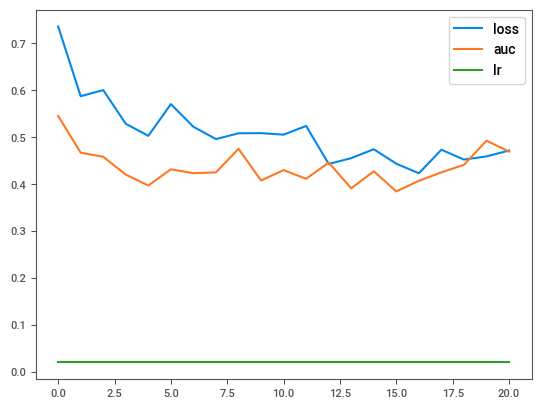

In [23]:
# plot losses
plt.plot(clf.history['loss'], label='loss')
# plot auc
plt.plot(clf.history['val_auc'], label='auc')
# plot learning rates
plt.plot(clf.history['lr'], label='lr')
plt.legend()

<BarContainer object of 6 artists>

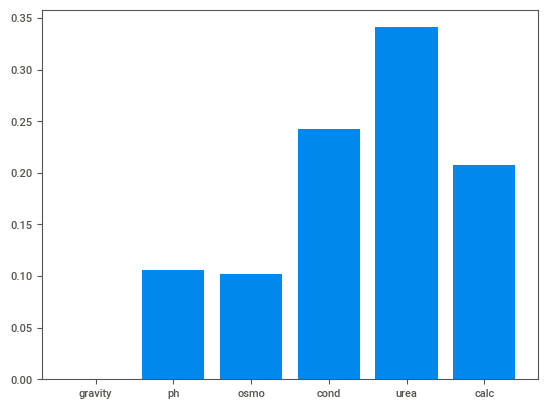

In [24]:
plt.bar(features, clf.feature_importances_)

#  keras

In [25]:
from sklearn.metrics import roc_auc_score

# Define a custom metric to calculate AUC for each batch
def auc(y_true, y_pred):
    auc_score = tf.py_function(roc_auc_score, (y_true, y_pred), tf.float64)
    return auc_score

model = keras.Sequential([
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
        ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
model.compile(optimizer = optimizer,
             loss = "binary_crossentropy",
             metrics = ["accuracy", auc]
             )
# model.fit(train_x_scaled, train_y,
#           epochs = 37, batch_size = 8)
#loss: 0.5082 - accuracy: 0.7947

# Train and evaluate model with KFold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Fit the model to the training data
    model.fit(
        X_train, y_train,
        epochs=30, batch_size=64,
        validation_data=(X_test, y_test)
    )

    # Evaluate the model on the test data
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {scores[1]*100:.2f}%")

Epoch 1/30
6/6 [==============================] - 2s 77ms/step - loss: 9.9866 - accuracy: 0.4411 - auc: 0.6431 - val_loss: 4.3064 - val_accuracy: 0.4578 - val_auc: 0.8237
Epoch 2/30
6/6 [==============================] - 0s 15ms/step - loss: 6.0756 - accuracy: 0.4411 - auc: 0.5525 - val_loss: 1.9378 - val_accuracy: 0.4578 - val_auc: 0.8079
Epoch 3/30
6/6 [==============================] - 0s 15ms/step - loss: 3.1676 - accuracy: 0.4502 - auc: 0.5640 - val_loss: 0.7022 - val_accuracy: 0.3976 - val_auc: 0.4966
Epoch 4/30
6/6 [==============================] - 0s 16ms/step - loss: 1.8113 - accuracy: 0.4683 - auc: 0.5865 - val_loss: 0.6951 - val_accuracy: 0.5663 - val_auc: 0.6322
Epoch 5/30
6/6 [==============================] - 0s 15ms/step - loss: 1.4446 - accuracy: 0.5136 - auc: 0.5140 - val_loss: 0.9095 - val_accuracy: 0.5422 - val_auc: 0.3721
Epoch 6/30
6/6 [==============================] - 0s 16ms/step - loss: 1.2702 - accuracy: 0.5045 - auc: 0.5109 - val_loss: 0.8988 - val_accuracy: